In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm import tqdm_notebook

from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error

from scipy import sparse

%matplotlib inline

Идеи:
- построение кривых обучения - нужны ли все данные?

In [2]:
def write_submission_file(prediction, filename, timestamp=False):
    
    sample_submission = pd.read_csv('./data/sample_submission.csv', index_col='id')
    sample_submission['log_recommends'] = prediction
    
    if timestamp:
        full_filename = '{}_{}.csv'.format(filename, datetime.now().strftime('%m%d_%H%M'))
    else:
        full_filename = '{}.csv'.format(filename)
    
    sample_submission.to_csv('./submissions/{}'.format(full_filename))

<b>targets on test_data: target = log1p(recommendations) = log(1 + recommendations)</b>
<br>inverse transformation: exp1m(x) = exp(x) -1

Some ideas for improvement:
- Engineer good features, this is the key to success. Some simple features will be based on publication time, authors, content length and so on
- You may not ignore HTML and extract some features from there
- You'd better experiment with your validation scheme. You should see a correlation between your local improvements and LB score
- Try TF-IDF, ngrams, Word2Vec and GloVe embeddings
- Try various NLP techniques like stemming and lemmatization
- Tune hyperparameters. In our example, we've left only 50k features and used `C`=1 as a regularization parameter, this can be changed 
- SGD and Vowpal Wabbit will learn much faster
- In our course, we don't cover neural nets. But it's not obliged to use GRUs or LSTMs in this competition. 

## load processed data

### author

In [3]:
df_train_author = pd.read_csv('./data/processed/train_author.csv', encoding='utf-8', index_col=0)
df_test_author = pd.read_csv('./data/processed/test_author.csv', encoding='utf-8', index_col=0)

In [4]:
url_to_name = lambda url: url[url.find('@') + 1:]

df_train_author['name'] = df_train_author['url'].apply(url_to_name)
df_train_author['twitter'].fillna('', inplace=True)

df_test_author['name'] = df_test_author['url'].apply(url_to_name)
df_test_author['twitter'].fillna('', inplace=True)

In [5]:
df_train_author.head()

,name,twitter,url
0,Medium,@Medium,https://medium.com/@Medium
1,Medium,@Medium,https://medium.com/@Medium
2,aelcenganda,@aelcenganda,https://medium.com/@aelcenganda
3,vaibhavkhulbe,@vaibhav_khulbe,https://medium.com/@vaibhavkhulbe
4,vaibhavkhulbe,@vaibhav_khulbe,https://medium.com/@vaibhavkhulbe


In [6]:
df_train_author.shape, df_test_author.shape

((62313, 3), (34645, 3))

### content

In [7]:
df_train_content = pd.read_csv('./data/processed/train_content.csv', encoding='utf-8', index_col=0)
df_test_content = pd.read_csv('./data/processed/test_content.csv', encoding='utf-8', index_col=0)

In [8]:
df_train_content.head()

,content
0,"MediumEveryone’s stories and ideasAug 13, 2012..."
1,"MediumEveryone’s stories and ideasAug 2, 2015 ..."
2,"Yun-Chen Chien（簡韻真）Nobody in @g0v.tw, PM in se..."
3,Vaibhav KhulbeAndroid App Developer | I write ...
4,Vaibhav KhulbeAndroid App Developer | I write ...


In [9]:
df_train_content.shape, df_test_content.shape

((62313, 1), (34645, 1))

### published

In [10]:
df_train_published = pd.read_csv('./data/processed/train_published.csv', encoding='utf-8', index_col=0)
df_test_published = pd.read_csv('./data/processed/test_published.csv', encoding='utf-8', index_col=0)

In [11]:
df_train_published['published'] = df_train_published['published'].apply(pd.to_datetime)
df_test_published['published'] = df_test_published['published'].apply(pd.to_datetime)

In [12]:
df_train_published.head()

,published
0,2012-08-13 22:54:53.510
1,2015-08-03 07:44:50.331
2,2017-02-05 13:08:17.410
3,2017-05-06 08:16:30.776
4,2017-06-04 14:46:25.772


In [13]:
df_train_published.shape, df_test_published.shape

((62313, 1), (34645, 1))

### title

In [14]:
df_train_title = pd.read_csv('./data/processed/train_title.csv', encoding='utf-8', index_col=0)
df_test_title = pd.read_csv('./data/processed/test_title.csv', encoding='utf-8', index_col=0)

In [15]:
df_train_title.head()

,title
0,Medium Terms of Service – Medium Policy – Medium
1,Amendment to Medium Terms of Service Applicabl...
2,走入山與海之間：閩東大刀會和兩岸走私 – Yun-Chen Chien（簡韻真） – Medium
3,How fast can a camera get? – What comes to min...
4,A game for the lonely fox – What comes to mind...


In [16]:
df_train_title.shape, df_test_title.shape

((62313, 1), (34645, 1))

### log_recommends

In [17]:
df_log_recommends = pd.read_csv('./data/train_log1p_recommends.csv')[['log_recommends']]

In [18]:
df_log_recommends.head()

,log_recommends
0,9.01201
1,3.49651
2,0.69315
3,1.38629
4,1.94591


In [19]:
df_log_recommends.shape

(62313, 1)

## merge and sort data 

In [20]:
df_train = pd.concat([df_train_author, df_train_content, df_train_published, df_train_title, df_log_recommends], axis=1)
df_test = pd.concat([df_test_author, df_test_content, df_test_published, df_test_title], axis=1)

In [21]:
df_train = df_train.sort_values(by='published')

In [22]:
df_train.shape, df_test.shape

((62313, 7), (34645, 6))

## features engineering

In [23]:
new_features_train = []
new_features_test = []

### author

In [24]:
df_train_author_name = df_train['name']
df_test_author_name = df_test['name']

#### insert na_string in dataframes

In [25]:
na_string = 'unknown_author'

print('train and test contains na_string:', na_string in df_train_author_name.values, na_string in df_test_author_name.values)
print('unique nameis in train and test:', len(df_train_author_name.unique()), len(df_test_author_name.unique()))
print('intersection of train and test:', len(set(df_train_author_name.values) & set(df_test_author_name.values)))

train and test contains na_string: False False
unique nameis in train and test: 31540 18451
intersection of train and test: 5746


In [26]:
def analyse_authors(name):
    if name not in df_train_author_name.values:
        return na_string
    else:
        return name

In [27]:
df_train_author_name_with_na = df_train_author_name.append(pd.Series([na_string]), ignore_index=True)
df_test_author_name_with_na = df_test_author_name.apply(analyse_authors)

In [28]:
print('unique nameis in train and test after processing:', 
      len(df_train_author_name_with_na.unique()), 
      len(df_test_author_name_with_na.unique()))

unique nameis in train and test after processing: 31541 5747


#### one-hot-encoding

In [29]:
author_le = LabelEncoder()

In [30]:
%%time

author_le.fit(df_train_author_name_with_na)

df_train_author_name_le = pd.DataFrame(author_le.transform(df_train_author_name_with_na), columns=['name'])
df_test_author_name_le = pd.DataFrame(author_le.transform(df_test_author_name_with_na), columns=['name'])

Wall time: 350 ms


In [31]:
author_ohe = OneHotEncoder()

In [32]:
%%time

author_ohe.fit(df_train_author_name_le)

# remember to remove na_string from train!
df_train_author_name_ohe = author_ohe.transform(df_train_author_name_le.iloc[:-1, :])
df_test_author_name_ohe = author_ohe.transform(df_test_author_name_le)

Wall time: 16.6 ms


In [33]:
print('ohe_df_train_author_name:', df_train_author_name_ohe.shape)
print('ohe_df_test_author_name:', df_test_author_name_ohe.shape)

ohe_df_train_author_name: (62313, 31541)
ohe_df_test_author_name: (34645, 31541)


In [34]:
new_features_train.append(df_train_author_name_ohe)
new_features_test.append(df_test_author_name_ohe)

### content

In [35]:
# %%time

# content_tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)

# content_tfidf.fit(df_train['content'])

# train_content_tfidf = content_tfidf.transform(df_train['content'])
# test_content_tfidf = content_tfidf.transform(df_test['content'])

# sparse.save_npz('./data/processed/train_content_tfidf.npz', train_content_tfidf)
# sparse.save_npz('./data/processed/test_content_tfidf.npz', test_content_tfidf)

In [36]:
new_features_train.append(sparse.load_npz('./data/processed/train_content_tfidf.npz'))
new_features_test.append(sparse.load_npz('./data/processed/test_content_tfidf.npz'))

### published

#### hour

In [37]:
hour_ohe = OneHotEncoder()

In [38]:
df_train_published_hour = df_train['published'].apply(lambda dt: dt.hour).values.reshape(-1, 1)
df_test_published_hour = df_test['published'].apply(lambda dt: dt.hour).values.reshape(-1, 1)

In [39]:
hour_ohe.fit(df_train_published_hour)

new_features_train.append(hour_ohe.transform(df_train_published_hour))
new_features_test.append(hour_ohe.transform(df_test_published_hour))

#### daytime

In [40]:
def get_daytime(dt):
    # morning
    if (dt.hour >= 5) & (dt.hour <=12):
        return 1 
    # day
    elif (dt.hour >=13) & (dt.hour <=21):
        return 2 
    # night
    else:
        return 3 

In [41]:
daytime_ohe = OneHotEncoder()

In [42]:
df_train_published_daytime = df_train['published'].apply(get_daytime).values.reshape(-1, 1)
df_test_published_daytime = df_test['published'].apply(get_daytime).values.reshape(-1, 1)

In [43]:
daytime_ohe.fit(df_train_published_daytime)

new_features_train.append(daytime_ohe.transform(df_train_published_daytime))
new_features_test.append(daytime_ohe.transform(df_test_published_daytime))

#### weekend

In [44]:
def get_weekend_flag(dt):
    if dt.dayofweek == 5 | dt.dayofweek == 6:
        return 1
    else:
        return 0

In [45]:
df_train_published_weekend = pd.DataFrame(df_train['published'].apply(get_weekend_flag).values.reshape(-1, 1), 
                                          columns=['published_weekend'])

df_test_published_weekend = pd.DataFrame(df_test['published'].apply(get_weekend_flag).values.reshape(-1, 1), 
                                         columns=['published_weekend'])

In [46]:
new_features_train.append(df_train_published_weekend)
new_features_test.append(df_test_published_weekend)

### title

In [47]:
title_tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=100000)

In [48]:
%%time

title_tfidf.fit(df_train['title'])

new_features_train.append(title_tfidf.transform(df_train['title']))
new_features_test.append(title_tfidf.transform(df_test['title']))

Wall time: 4.22 s


## join features and load target data

In [49]:
for feat in new_features_train:
    print(type(feat), feat.shape)

<class 'scipy.sparse.csr.csr_matrix'> (62313, 31541)
<class 'scipy.sparse.csr.csr_matrix'> (62313, 100000)
<class 'scipy.sparse.csr.csr_matrix'> (62313, 24)
<class 'scipy.sparse.csr.csr_matrix'> (62313, 3)
<class 'pandas.core.frame.DataFrame'> (62313, 1)
<class 'scipy.sparse.csr.csr_matrix'> (62313, 100000)


In [50]:
for feat in new_features_test:
    print(type(feat), feat.shape)

<class 'scipy.sparse.csr.csr_matrix'> (34645, 31541)
<class 'scipy.sparse.csr.csr_matrix'> (34645, 100000)
<class 'scipy.sparse.csr.csr_matrix'> (34645, 24)
<class 'scipy.sparse.csr.csr_matrix'> (34645, 3)
<class 'pandas.core.frame.DataFrame'> (34645, 1)
<class 'scipy.sparse.csr.csr_matrix'> (34645, 100000)


In [51]:
X_train_full = sparse.csr_matrix(sparse.hstack(new_features_train))
X_test_full = sparse.csr_matrix(sparse.hstack(new_features_test))

y_train_full = df_train['log_recommends'].values

print('X_train_full:', X_train_full.shape)
print('X_test_full:', X_test_full.shape)
print('y_train_full:', y_train_full.shape)

X_train_full: (62313, 231569)
X_test_full: (34645, 231569)
y_train_full: (62313,)


### split data to validation

In [52]:
train_size = 0.7

train_idx = int(X_train_full.shape[0] * train_size)

X_train = X_train_full[:train_idx, :]
y_train = y_train_full[:train_idx]
X_holdout = X_train_full[train_idx:, :]
y_holdout = y_train_full[train_idx:]

In [53]:
### split data to validation

train_size = 0.7

train_idx = int(X_train_full.shape[0] * train_size)

X_train = X_train_full[:train_idx, :]
y_train = y_train_full[:train_idx]
X_holdout = X_train_full[train_idx:, :]
y_holdout = y_train_full[train_idx:]

### ridge estimator

In [54]:
estimator = Ridge(alpha=1.0, random_state=14)

In [55]:
%%time

estimator.fit(X_train, y_train)

Wall time: 50.2 s


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=14, solver='auto', tol=0.001)

In [56]:
ridge_holdout_prediction = estimator.predict(X_holdout)

holdout_mae = mean_absolute_error(y_holdout, ridge_holdout_prediction)
print('holdout_mae = {} expm1_holdout_mae = {}'.format(holdout_mae, np.expm1(holdout_mae)))

holdout_mae = 1.1418147859541334 expm1_holdout_mae = 2.1324479325378722


### ridge manual param search

In [57]:
# alpha_range = np.logspace(-1.5, 1.5, 15)

# for idx, alpha in enumerate(alpha_range):
#     print('{} -> {}'.format(idx, alpha))

In [58]:
# %%time

# ridges = []
# train_scores = []
# holdout_scores = []

# for alpha in tqdm_notebook(alpha_range):
    
#     cur_ridge = Ridge(alpha=alpha)
#     cur_ridge.fit(X_train, y_train)
    
#     train_score = mean_absolute_error(y_train, cur_ridge.predict(X_train))
#     holdout_score = mean_absolute_error(y_holdout, cur_ridge.predict(X_holdout))
    
#     ridges.append(cur_ridge)
#     train_scores.append(train_score)
#     holdout_scores.append(holdout_score)

In [59]:
# plt.figure(figsize=(15, 5))

# plt.plot(range(len(alpha_range)), train_scores, color='red', label='train')
# plt.plot(range(len(alpha_range)), holdout_scores, color='blue', label='holdout')

# #plt.ylim(0.94, 1.01)
# #plt.xlim(18, 22)
# plt.xlabel("alpha index")
# plt.ylabel("MAE")
# plt.legend()
# plt.grid()
# plt.show()

In [60]:
# print('best holdout score:', np.max(holdout_scores))
# print('best alpha:', alpha_range[np.argmax(holdout_scores)])
# print('best alpha index:', np.argmax(holdout_scores))

# ms_best_estimator = ridges[np.argmax(holdout_scores)]

### refit and make prediction file

In [84]:
%%time

estimator.fit(X_train_full, y_train_full)

Wall time: 56.4 s


In [90]:
ridge_test_prediction = estimator.predict(X_test_full)

write_submission_file(ridge_test_prediction, 'prediction', timestamp=True)

### make null submission

In [ ]:
# private lb result: 4.33328

#zeros_prediction = np.zeros_like(ridge_test_prediction)

#write_submission_file(zeros_prediction, 'zeros_prediction', timestamp=False)

### prediction exploration

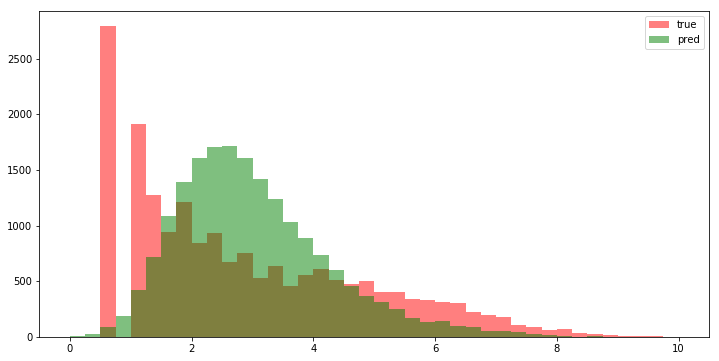

In [65]:
plt.figure(figsize=(12, 6))
plt.hist(y_holdout, bins=40, alpha=0.5, color='red', label='true', range=(0, 10))
plt.hist(ridge_holdout_prediction, bins=40, alpha=0.5, color='green', label='pred', range=(0, 10))
plt.legend()
plt.show()

In [80]:
median_delta = np.median(ridge_holdout_prediction) - np.median(y_holdout)
mae = mean_absolute_error(y_holdout, ridge_holdout_prediction)

print('y_holdout mean:', np.mean(y_holdout))
print('ridge_holdout_prediction mean:', np.mean(ridge_holdout_prediction))
print('median_delta:', median_delta)
print('mae:', mae)

y_holdout mean: 2.8765493436396703
ridge_holdout_prediction mean: 3.007800809889073
median_delta: 0.41272376762590746
mae: 1.1418147859541334


In [87]:
ridge_holdout_prediction_offset = ridge_holdout_prediction - median_delta
mae_offset = mean_absolute_error(y_holdout, ridge_holdout_prediction_offset)

print('mae_offset:', mae_offset)

mae_offset: 1.1158746987815245


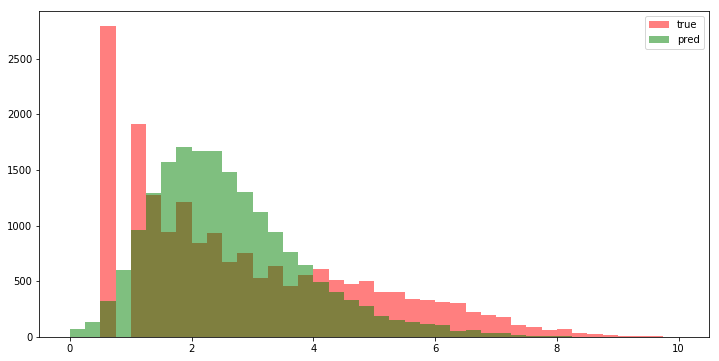

In [88]:
plt.figure(figsize=(12, 6))
plt.hist(y_holdout, bins=40, alpha=0.5, color='red', label='true', range=(0, 10))
plt.hist(ridge_holdout_prediction_offset, bins=40, alpha=0.5, color='green', label='pred', range=(0, 10))
plt.legend()
plt.show()

In [100]:
test_mean_delta = 4.33328 - np.mean(ridge_test_prediction)

print('test_mean_delta:', test_mean_delta)

test_mean_delta: 1.1503067512219958


In [ ]:
ridge_test_prediction_offset = ridge_test_prediction + test_mean_delta

In [99]:
write_submission_file(ridge_test_prediction_offset, 'prediction_offset', timestamp=False)